<a href="https://colab.research.google.com/github/arkalim/PyTorch/blob/master/Facial_Landmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import time
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [0]:
if not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):
    !wget http://dlib.net/files/data/ibug_300W_large_face_landmark_dataset.tar.gz
    !tar -xvzf 'ibug_300W_large_face_landmark_dataset.tar.gz'    
    !rm -r 'ibug_300W_large_face_landmark_dataset.tar.gz'

## Visualize the dataset

68


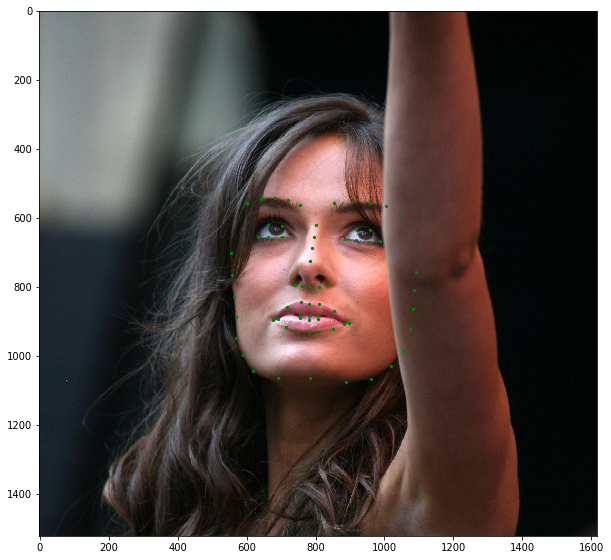

In [0]:
file = open('ibug_300W_large_face_landmark_dataset/helen/trainset/100032540_1.pts')
points = file.readlines()[3:-1]

landmarks = []

for point in points:
    x,y = point.split(' ')
    landmarks.append([floor(float(x)), floor(float(y[:-1]))])
    
landmarks = np.array(landmarks) 
print(len(landmarks))

plt.figure(figsize=(10,10))
plt.imshow(mpimg.imread('ibug_300W_large_face_landmark_dataset/helen/trainset/100032540_1.jpg'))
plt.scatter(landmarks[:,0], landmarks[:,1], s = 5, c = 'g')
plt.show()

## Create dataset class

In [0]:
class FaceLandmarksDataset(Dataset):
    """Facial Landmarks dataset."""

    def __init__(self, root_dir, transform=None):

        self.filenames = []
        self.transform = transform
        self.root_dir = root_dir
        
        for filename in os.listdir(root_dir):
            if filename[:-4].endswith('mirror') is False:
                self.filenames.append(filename[:-4]) 
                
        self.filenames = np.unique(self.filenames)        

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        
        image = mpimg.imread(os.path.join(self.root_dir, self.filenames[index])+'.jpg')
        
        # when image is grayscale stack three grayscale images to get a colored image
        if (len(image.shape)==2):
            image = np.stack((image,)*3, -1)

        # if the image has a depth of 4
        # remove the alpha channel
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        file = open(os.path.join(self.root_dir, self.filenames[index])+'.pts')
        points = file.readlines()[3:-1]

        landmarks = []

        for point in points:
            x,y = point.split(' ')
            landmarks.append([floor(float(x)), floor(float(y[:-1]))])

        landmarks = np.array(landmarks)
        landmarks = landmarks.astype('float')
        
        if self.transform:
            sample = self.transform({'image': image, 'landmarks': landmarks})

        return sample

## Custom Transforms

In [0]:
class Normalize_Image(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""
    
    def __init__(self):
        pass

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # scale color range from [0, 255] to [0, 1]
        image =  image/255.0

        return {'image': image, 'landmarks': landmarks}
    
class Normalize_Landmarks(object):
    """Convert the Landmarks range to [0,1]."""
    
    def __init__(self, cropsize):
        self.cropsize = cropsize

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        # to change the range to [-1, 1] uncomment the below
        #s = self.cropsize / 2
        #landmarks = (landmarks - s)/self.cropsize
        
        # to change the range to [0, 1] 
        landmarks = landmarks/self.cropsize

        return {'image': image, 'landmarks': landmarks}
    
        

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        
        # output size can be both int and tuple
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        
        # obtain image and landmark using the keys for the dict
        image, landmarks = sample['image'], sample['landmarks']

        # shape of the image is the first two axes
        h, w = image.shape[:2]
        
        # if the output_size is int
        if isinstance(self.output_size, int):
            
            # smaller of image edges is matched to output_size keeping aspect ratio the same.
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h        
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop is made.
    """

    def __init__(self, output_size):
        
        # output size can be both int and tuple
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        
        # obtain image and landmark using the keys for the dict
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h, left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks= sample['image'], sample['landmarks']

        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))

        return {'image': torch.from_numpy(image).double(), 'landmarks': torch.from_numpy(landmarks).double()}

class RandomFlip(object):
    """Randomly flip image and keypoints to match"""

    def __call__(self, sample):
        
        image, landmarks= sample['image'], sample['landmarks']

        if len(image.shape) ==3:
            h, w, _ = image.shape
            
        if len(image.shape) ==2:
            h, w = image.shape    
            
        if np.random.choice((True, False)):
            image = cv2.flip(image,1)

            landmarks[:,0] = w - landmarks[:,0]
            
            pairs = [[0, 16], [1, 15], [2, 14], [3, 13], [4, 12], [5, 11], [6, 10],
                 [7, 9], [17, 26], [18, 25], [19, 24], [20, 23], [21, 22], [36, 45],
                 [37, 44], [38, 43], [39, 42], [41, 46], [40, 47], [31, 35], [32, 34],
                 [50, 52], [49, 53], [48, 54], [61, 63], [60, 64], [67, 65], [59, 55], [58, 56]]

            for matched_p in pairs:

                idx1, idx2 = matched_p[0], matched_p[1]
                tmp = np.copy(landmarks[idx1])
                landmarks[idx1] =np.copy(landmarks[idx2])
                landmarks[idx2] =tmp

        return {'image': image, 'landmarks': landmarks}


class Brightness(object):

    def __init__(self, var=0.2):
        self.var = var

    def __call__(self, sample):
        
        image, landmarks= sample['image'], sample['landmarks']

        #if png
        if image.any()<1:
            image=image*255

        # convert to HSV so that its easy to adjust brightness
        image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)

        image = np.array(image, dtype = np.float64)

        random_bright = np.random.uniform(low=1-self.var, high=1+self.var)

        image[:,:,2] = (image[:,:,2]*random_bright)
        image[:,:,2][image[:,:,2]>255]  = 255
        image[:,:,2][image[:,:,2]<0]  = 0

        # convert to RBG again
        image = np.array(image, dtype = np.uint8)
        image = cv2.cvtColor(image,cv2.COLOR_HSV2RGB)

        return {'image': image, 'landmarks': landmarks}
    
class Grayscale(object):

    def __call__(self, sample):
        
        image, landmarks= sample['image'], sample['landmarks']

        image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

        return {'image': image, 'landmarks': landmarks}    

In [0]:
# compose the two transforms
train_transform = transforms.Compose([Brightness(0.5),
                                      Grayscale(),
                                      Normalize_Image(),
                                      Rescale(256),
                                      RandomCrop(224),
                                      RandomFlip(),
                                      Normalize_Landmarks(cropsize = 224),
                                      ToTensor(),
                                     ])

dataset = FaceLandmarksDataset('ibug_300W_large_face_landmark_dataset/helen/trainset', train_transform)

## Split the dataset into train and valid dataset

In [0]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
new_len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(new_len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [new_len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=True)

The length of Train set is 1800
The length of Valid set is 200


## Visualise training dataset

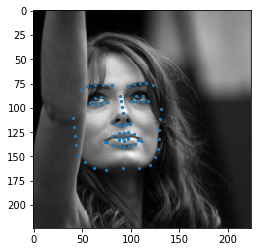

In [0]:
sample = dataset[0]

image = sample['image']
landmarks = sample['landmarks']

# denormalize the landmarks
landmarks = landmarks * 224

plt.imshow(image.numpy().transpose(1,2,0).squeeze(), cmap='gray')
plt.scatter(landmarks[:,0], landmarks[:,1], s=5)

### Testing the shape of input data

torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])


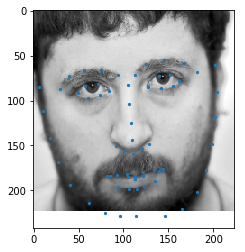

In [0]:
samples = next(iter(train_loader))

images = samples['image']
landmarks = samples['landmarks'] * 224

print(images.shape)
print(landmarks.shape)

plt.imshow(images[0].numpy().transpose(1,2,0).squeeze(), cmap='gray')
plt.scatter(landmarks[0,:,0], landmarks[0,:,1], s=5)

## Define the model
Here, I modified Resnet 18 to input a grayscale image 

In [0]:
class BasicBlock(nn.Module):
    '''Basic Block is used in resnet 18 and 34. It consists of two 3x3 convolutions.
       Relu activation function is added after adding the skip connection. There is no 
       expansion of features in case of basic blocks'''
    expansion = 1
    def __init__(self , input_channels , output_channels , stride = 1 , dim_change = None):
        super(BasicBlock , self).__init__()
        self.conv1 = nn.Conv2d(input_channels , output_channels , stride = stride , kernel_size = 3 , padding = 1, bias=False)
        self.bn1 = nn.BatchNorm2d(output_channels)
        self.conv2 = nn.Conv2d(output_channels , output_channels , stride = 1 , kernel_size = 3 , padding = 1, bias=False)
        self.bn2 = nn.BatchNorm2d(output_channels)
        self.dim_change = dim_change
        
    def forward(self , x):
        residual_connection = x
        output = F.relu(self.bn1(self.conv1(x)))
        # relu to be added after concatenation
        output = self.bn2(self.conv2(output))
        
        #But first we will check for dimension change
        if self.dim_change is not None:
            residual_connection = self.dim_change(residual_connection)
            
        output = residual_connection + output
        output = F.relu(output)
        return output
    
class ResNet(nn.Module):
    def __init__(self , block , num_layers , classes = 1000):
        '''
        The block can be bottleneck block or basic block and num_layers is the
        number of layers required for each block. num_layers will be a list containing 
        the number of blocks in each layer
        '''
        super(ResNet , self).__init__()
        self.input_size = 64
        
        # First layer in all is 7*7 convolution with stride 2, it contains 64 channels
        self.conv1 = nn.Conv2d(1, 64 , stride = 2 , kernel_size = 7, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # comment maxpool if you want to use it for cifar10 since image size is 
        # small 32*32 and maxpool would make it even smaller for processing
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        ##################### Main Building Blocks ####################
        
        # for 1st layer(block) all the 3x3 convolutions will take place using 64 filters
        # for 2nd block, 128 filters and so on.
        self.layer1 = self.make_layer(block , 64 , num_layers[0] , stride = 1)
        self.layer2 = self.make_layer(block , 128 , num_layers[1] , stride = 2)
        self.layer3 = self.make_layer(block , 256 , num_layers[2] , stride = 2)
        self.layer4 = self.make_layer(block , 512 , num_layers[3] , stride = 2)
        
        # last linear layer consisting of 2048 filters as input and num_classes as output
        self.fc = nn.Linear(512*block.expansion , 136)
        
    def make_layer(self , block , input_size ,num_layers , stride=1):
        downsample = None
        # we have to find the condition for change of dimensions
        # basically saying that change for dimensions 128,256,512
        # input size gets updated later
        if stride!=1 or input_size!=self.input_size*block.expansion:
            downsample = nn.Sequential(nn.Conv2d(self.input_size , input_size*block.expansion , kernel_size = 1 , 
                                                 stride = stride, bias=False),
                                       nn.BatchNorm2d(input_size*block.expansion))
            
        # empty list to append the layers to    
        layers = []
        # appending the layers
        layers.append(block(self.input_size , input_size , stride , downsample))
        self.input_size = input_size*block.expansion
        
        for i in range(1,num_layers):
            layers.append(block(self.input_size , input_size))
            
        return nn.Sequential(*layers)
        
    def forward(self , x):
        # initial convolution 
        x = F.relu(self.maxpool(self.bn1(self.conv1(x))))
        
        # The 4 layers (blocks)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = F.avg_pool2d(x, kernel_size=4) 
        x = x.reshape(x.size(0) , -1)
        x = self.fc(x)
        return x          
    
def Create_Resnet(arch='resnet50', pretrained = False, classes=1000):
    
    if arch == 'resnet18':
        resnet = ResNet(BasicBlock , [2,2,2,2] , classes)
    elif arch == 'resnet34':
        resnet = ResNet(BasicBlock , [3,4,6,3] , classes)
    elif arch == 'resnet50':
        resnet = ResNet(BottleNeck , [3,4,6,3] , classes)
    elif arch == 'resnet101':
        resnet = ResNet(BottleNeck , [3,4,23,3] , classes)
    elif arch == '152':
        resnet = ResNet(BottleNeck , [3,8,36,3] , classes)

    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],progress=True)
        resnet.load_state_dict(state_dict)
    return resnet

network = Create_Resnet('resnet18')
network.cuda()   

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

## Load the current checkpoint to resume training 

In [0]:
network = Create_Resnet('resnet18')
network.cuda()
network.load_state_dict(torch.load('/content/face_landmarks.pth')) 
network.train()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

### Function to overwrite the console output

In [0]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    sys.stdout.flush()

In [0]:
# loss defined using torch.nn
criterion = nn.MSELoss()

# define the optimizer
optimizer = optim.Adam(network.parameters(), lr=0.000001)

# learning rate scheduler
#scheduler = ReduceLROnPlateau(optimizer, patience=1, factor=0.1, verbose=True)

# note the starting time to find the total time elapsed
start_time = time.time()

loss_min = 0.0016

num_epochs = 30

for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    # set the network into train mode
    network.train()
    
    for step in range(1,len(train_loader)+1):
    
        samples = next(iter(train_loader))
        
        # move the images and labels to GPU
        images = samples['image'].type(torch.FloatTensor).cuda()
        landmarks = samples['landmarks'].type(torch.FloatTensor).cuda()
        
        predictions = network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks.view(landmarks.size(0),-1))
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    network.eval() 
    
    # turn the gradients off for validation
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            samples = next(iter(valid_loader))
        
            # move the images and labels to GPU
            images = samples['image'].type(torch.FloatTensor).cuda()
            landmarks = samples['landmarks'].type(torch.FloatTensor).cuda()
        
            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks.view(landmarks.size(0),-1))

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    
    # call the learning rate scheduler on valid_loss
    #scheduler.step(loss_valid)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), '/content/face_landmarks.pth') 
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
    
# find the time at the end of training    
end_time = time.time()

print('Training Complete')
print("Total Elapsed Time : {} s".format(end_time - start_time))

## Load the best model

In [0]:
best_network = Create_Resnet('resnet18')
best_network.cuda()
best_network.load_state_dict(torch.load('/content/face_landmarks.pth')) 
best_network.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

## Test our model

Total number of test images: 200
Elapsed Time : 6.353983640670776


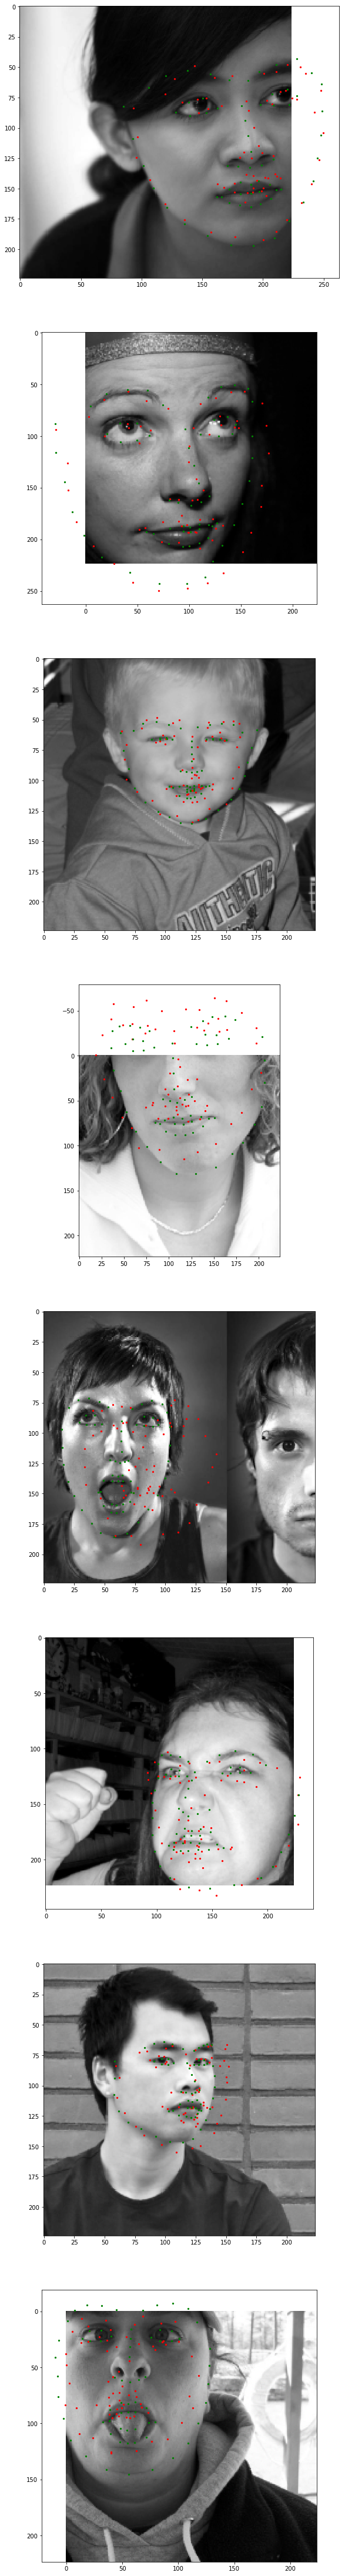

In [0]:
def test_model(model):
    
    start_time = time.time()

    with torch.no_grad():
        
        samples = next(iter(valid_loader))

        # move the images and labels to GPU
        images = samples['image'].type(torch.FloatTensor).cuda()
        landmarks = samples['landmarks'].type(torch.FloatTensor).cpu() * 224

        predictions = network(images).cpu() * 224
        predictions = predictions.view(16,68,2)
        
        plt.figure(figsize=(10,80))
        
        for img_num in range(8):
            plt.subplot(8,1,img_num+1)
            plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
            plt.scatter(predictions[img_num,:,0], predictions[img_num,:,1], c = 'r', s = 5)
            plt.scatter(landmarks[img_num,:,0], landmarks[img_num,:,1], c = 'g', s = 5)

    print('Total number of test images: {}'.format(len(valid_dataset)))

    end_time = time.time()
    print("Elapsed Time : {}".format(end_time - start_time))
    
test_model(best_network)    

## Test on custom images

Elapsed Time : 0.04450869560241699


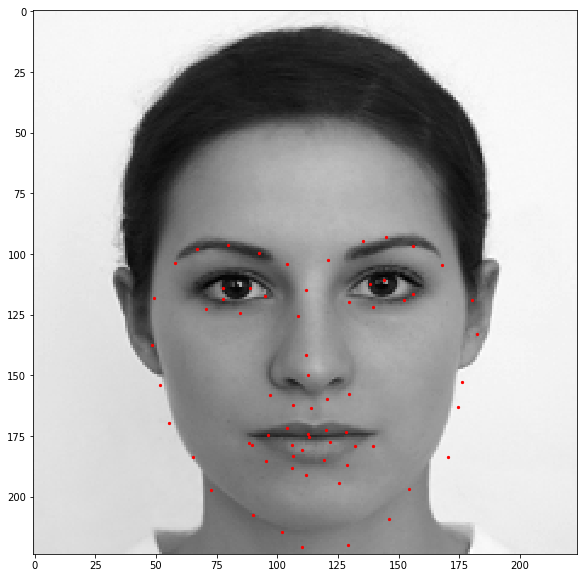

In [0]:
!wget https://www.uni-regensburg.de/Fakultaeten/phil_Fak_II/Psychologie/Psy_II/beautycheck/english/prototypen/w_sexy_gr.jpg

def test(model):
    
    start_time = time.time()

    with torch.no_grad():
        
        image = mpimg.imread('w_sexy_gr.jpg')
        image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        image = cv2.resize(image, (224,250))
        image = image[:224,:224]
        final_image = image/255.0

        image = torch.tensor(final_image, dtype = torch.float32).cuda().unsqueeze(0).unsqueeze(1)

        predictions = network(image).cpu() * 224
        predictions = predictions.view(1,68,2)
        
        plt.figure(figsize=(10,10))
        plt.imshow(final_image, cmap = 'gray')
        plt.scatter(predictions[0,:,0], predictions[0,:,1], c = 'r', s = 5)

    end_time = time.time()
    print("Elapsed Time : {}".format(end_time - start_time))
    
test(best_network)    